# Lab 07: Exploratory Data Analysis, Preprocessing & Evaluation Splits

**ING3513 - Introduction to Artificial Intelligence and Machine Learning**

Today's lab is a practical walkthrough of how to interrogate a dataset before modeling, clean up issues, scale features, and design evaluation splits that keep you honest. You'll combine visual intuition (Seaborn) with scikit-learn utilities to spot data quality traps before they ruin your models.

**What you'll learn:**

- **Summary statistics** — quick ways to spot suspicious distributions
- **Missing values & outliers** — detection, visualization, and handling strategies
- **Normalization** — when to use StandardScaler vs MinMaxScaler, and how to denormalize for interpretation
- **Correlation & redundancy** — identifying multicollinearity and potential leakage
- **Evaluation splits** — train/test, train/val/test, and cross-validation protocols

### Scope: What This Lab _Is_

- Understanding data quality, feature distributions, and relationships
- Practicing leakage-safe preprocessing with scikit-learn tools
- Comparing evaluation strategies (train/test, train/val/test, cross-validation)

### Scope: What This Lab _Is Not_

- Training state-of-the-art models or feature engineering for accuracy competitions
- Exhaustive hyperparameter tuning or advanced model selection

### A Note on Modeling

At the end of the lab (Part 8), we'll train a simple logistic regression model to predict passenger survival on the Titanic. But **prediction accuracy is not the goal** — the model serves purely to demonstrate how different evaluation splits affect reported performance and how scikit-learn pipelines prevent data leakage. Focus on the _methodology_, not the metrics.

### Why This Lab Exists

In Lab 06, you saw how gradient descent automatically finds optimal parameters by crawling along an error surface. But gradient descent assumes your data is clean, scaled, and split properly. **Bad data beats good models every time.**

Today, you'll learn to interrogate a dataset _before_ modeling — the skills that separate practitioners who get lucky from those who get reliable results.


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 5)

SEED = 42
rng = np.random.default_rng(SEED)

print("Libraries loaded successfully!")
print(f"pandas {pd.__version__} | numpy {np.__version__} | seaborn {sns.__version__}")

Libraries loaded successfully!
pandas 2.3.3 | numpy 2.4.1 | seaborn 0.13.2


## Part 0: Setup & Dataset

We'll use the classic **Titanic** dataset from Seaborn. This section establishes the contract for the rest of the lab: we load the data, decide on a target (`survived`), and identify columns that could leak information or should be dropped before modeling.

The Titanic dataset has real-world missingness (especially in `age` and `deck`), making it ideal for practicing missing-value detection. We also track feature roles (numerical vs. categorical, feature vs. target vs. leakage-prone) so preprocessing steps are explicit.


In [9]:
raw_titanic = sns.load_dataset("titanic")
df = raw_titanic.copy()

# Columns to drop before modeling (grouped by reason)
#
# 1. TRUE LEAKAGE — directly encodes the target
leakage_cols = ["alive"]  # "yes"/"no" is just survived in string form

# 2. DERIVED FEATURES — reconstructable from other columns (redundant)
derived_cols = ["adult_male", "who", "alone"]
# - adult_male: derived from sex + age (True if male >= 16)
# - who: derived from sex + age ("man"/"woman"/"child")
# - alone: derived from sibsp + parch (True if both are 0)

# 3. REDUNDANT ENCODINGS — same info, different format (pick one)
redundant_cols = ["class", "embark_town"]
# - class: categorical version of pclass ("First"/"Second"/"Third") — keep pclass
# - embark_town: full name of embarked ("Southampton" vs "S") — keep embarked

# 4. HIGH MISSINGNESS — not leakage, but ~77% missing
# deck could be informative (cabin location → class → survival), but we drop it
# for simplicity. Alternative: keep it and add "Unknown" category.
high_missing_cols = ["deck"]

# Combine all columns to exclude from features
drop_cols = leakage_cols + derived_cols + redundant_cols + high_missing_cols

target_col = "survived"
feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]

numeric_cols = [col for col in feature_cols if pd.api.types.is_numeric_dtype(df[col])]
categorical_cols = sorted(list(set(feature_cols) - set(numeric_cols)))

print(f"Dataset shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(
    f"Target column: {target_col} (classes: {sorted(df[target_col].dropna().unique())})"
)
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print()
print("Dropped columns:")
print(f"  Leakage:            {leakage_cols}")
print(f"  Derived:            {derived_cols}")
print(f"  Redundant encoding: {redundant_cols}")
print(f"  High missingness:   {high_missing_cols}")

print()
print("Class distribution (0 = died, 1 = survived):")
display(df[target_col].value_counts(dropna=False).to_frame("count"))

Dataset shape: 891 rows x 15 columns
Target column: survived (classes: [np.int64(0), np.int64(1)])
Feature columns (7): ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
Numeric features (5): ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical features (2): ['embarked', 'sex']

Dropped columns:
  Leakage:            ['alive']
  Derived:            ['adult_male', 'who', 'alone']
  Redundant encoding: ['class', 'embark_town']
  High missingness:   ['deck']

Class distribution (0 = died, 1 = survived):


,count
survived,
0,549
1,342


## Part 1: First Look

Quick reconnaissance helps you spot suspicious columns immediately. We'll inspect `df.head()` and a random sample to catch obvious data-entry issues, then report `df.shape` and `df.dtypes` to understand the column types.

Building a "column roles" table (ID-like, features, target) makes it explicit which columns need special treatment — categorical text, binary flags, timestamps, or identifiers that must be dropped before modeling.


In [10]:
print(f"Shape: {df.shape}")
print()
print("Peek at the first 5 rows:")
display(df.head())

print()
print("Random sample (5 rows)")
display(df.sample(5, random_state=SEED))

print()
print("Data types:")
print(df.dtypes)

column_roles = []
for col in df.columns:
    if col == target_col:
        role = "target"
    elif col in leakage_cols:
        role = "leakage (drop)"
    elif col in derived_cols:
        role = "derived (drop)"
    elif col in redundant_cols:
        role = "redundant encoding (drop)"
    elif col in high_missing_cols:
        role = "high missingness (drop)"
    elif col in feature_cols:
        role = "feature"
    else:
        role = "ignored"
    column_roles.append(
        {
            "column": col,
            "role": role,
            "dtype": str(df[col].dtype),
            "missing_%": round(df[col].isna().mean() * 100, 2),
        }
    )

roles_df = pd.DataFrame(column_roles).sort_values("role")
print()
print("Column role summary:")
display(roles_df)

Shape: (891, 15)

Peek at the first 5 rows:


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True



Random sample (5 rows)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
709,1,3,male,NaN,1,1,15.246,C,Third,man,True,NaN,Cherbourg,yes,False
439,0,2,male,31.0,0,0,10.500,S,Second,man,True,NaN,Southampton,no,True
840,0,3,male,20.0,0,0,7.925,S,Third,man,True,NaN,Southampton,no,True
720,1,2,female,6.0,0,1,33.000,S,Second,child,False,NaN,Southampton,yes,False
39,1,3,female,14.0,1,0,11.242,C,Third,child,False,NaN,Cherbourg,yes,False



Data types:
survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

Column role summary:


,column,role,dtype,missing_%
9,who,derived (drop),object,0.00
10,adult_male,derived (drop),bool,0.00
14,alone,derived (drop),bool,0.00
1,pclass,feature,int64,0.00
2,sex,feature,object,0.00
3,age,feature,float64,19.87
4,sibsp,feature,int64,0.00
5,parch,feature,int64,0.00
6,fare,feature,float64,0.00
7,embarked,feature,object,0.22


> **Prompt:** Look at the `alive` column values alongside `survived`. Why is this a textbook example of data leakage? What would happen to your test accuracy if you accidentally kept it as a feature?


## Part 2: Summary Statistics

Summary statistics give a quick snapshot of numeric columns. We use `df.describe().T` to see count, mean, std, min, quartiles, and max in one view.

**What to look for:**

- Columns with the largest standard deviation (most spread) — likely candidates for scaling.
- Columns with tiny standard deviation — possible near-constant features that add no signal.
- Min/max values outside believable domain ranges — signs of data-entry errors or sentinel values.


In [11]:
numeric_summary = df[numeric_cols].describe().T
print("Numeric summary (transpose):")
display(numeric_summary)

largest_std = numeric_summary.sort_values("std", ascending=False).head(3)["std"]
smallest_std = numeric_summary.sort_values("std", ascending=True).head(3)["std"]

print()
print("Top 3 columns by std (largest spread):")
display(largest_std.to_frame())
print()
print("Bottom 3 columns by std (near-constant risk):")
display(smallest_std.to_frame())

scale_candidates = numeric_summary[numeric_summary["std"] > 50].index.tolist()
near_constant = numeric_summary[numeric_summary["std"] < 5].index.tolist()
print()
print(f"Likely scaling candidates (std > 50): {scale_candidates}")
print(f"Potential near-constant numeric features (std < 5): {near_constant}")

# Domain rule checks
domain_rules = {
    "age": (0, 100),
    "fare": (0, 600),
    "sibsp": (0, 10),
    "parch": (0, 10),
    "pclass": (1, 3),
}
violations = []
for col, (lower, upper) in domain_rules.items():
    if col not in df.columns:
        continue
    mask = df[col].notna() & ((df[col] < lower) | (df[col] > upper))
    if mask.any():
        violations.append(
            {"column": col, "count": int(mask.sum()), "bounds": (lower, upper)}
        )

if violations:
    print()
    print("Possible domain violations:")
    display(pd.DataFrame(violations))
else:
    print()
    print("No domain-rule violations detected in numeric columns.")

Numeric summary (transpose):


,count,mean,std,min,25%,50%,75%,max
pclass,891.0,2.309,0.836,1.00,2.000,3.000,3.0,3.000
age,714.0,29.699,14.526,0.42,20.125,28.000,38.0,80.000
sibsp,891.0,0.523,1.103,0.00,0.000,0.000,1.0,8.000
parch,891.0,0.382,0.806,0.00,0.000,0.000,0.0,6.000
fare,891.0,32.204,49.693,0.00,7.910,14.454,31.0,512.329



Top 3 columns by std (largest spread):


,std
fare,49.693
age,14.526
sibsp,1.103



Bottom 3 columns by std (near-constant risk):


,std
parch,0.806
pclass,0.836
sibsp,1.103



Likely scaling candidates (std > 50): []
Potential near-constant numeric features (std < 5): ['pclass', 'sibsp', 'parch']

No domain-rule violations detected in numeric columns.


> **Prompt:** Based on standard deviations and ranges, which columns seem most in need of scaling? Are any columns suspiciously flat or impossible?


## Part 3: Data Sanity Checks

Before modeling, sanity-check the data for structural issues that can silently break your pipeline.

**Common checks:**

- **Duplicates** — `df.duplicated().sum()` counts exact row copies.
- **Near-constant columns** — features with very few unique values add no signal. `VarianceThreshold` from scikit-learn can flag these automatically.
- **Impossible values** — domain rules like "mass must be positive" catch data-entry errors.


In [12]:
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows (all columns): {duplicate_rows}")

unique_counts = df.nunique(dropna=False).sort_values()
print()
print("Unique values per column (including NaN):")
display(unique_counts.to_frame("unique_values"))

near_constant_features = [
    col for col in feature_cols if df[col].nunique(dropna=False) <= 3
]
print()
print(f"Near-constant feature candidates (<=3 unique values): {near_constant_features}")

# VarianceThreshold for numeric columns
filled_numeric = df[numeric_cols].fillna(df[numeric_cols].median())
vt = VarianceThreshold(threshold=1.0)
vt.fit(filled_numeric)
low_variance_mask = ~vt.get_support()
low_variance_cols = filled_numeric.columns[low_variance_mask].tolist()
print(
    f"VarianceThreshold flagged columns (variance < 1.0): {low_variance_cols if low_variance_cols else 'None'}"
)

# Impossible values check
impossible_checks = []
for col, (lower, upper) in domain_rules.items():
    if col not in df.columns:
        continue
    mask = df[col].notna() & ((df[col] < 0) | (df[col] > upper * 1.5))
    if mask.any():
        impossible_checks.append({"column": col, "count": int(mask.sum())})

if impossible_checks:
    print()
    print("Impossible values detected (needs manual review):")
    display(pd.DataFrame(impossible_checks))
else:
    print()
    print("No impossible-value violations detected (given current simple rules).")

Duplicate rows (all columns): 107

Unique values per column (including NaN):


,unique_values
survived,2
sex,2
alive,2
adult_male,2
alone,2
class,3
pclass,3
who,3
embarked,4
embark_town,4



Near-constant feature candidates (<=3 unique values): ['pclass', 'sex']
VarianceThreshold flagged columns (variance < 1.0): ['pclass', 'parch']

No impossible-value violations detected (given current simple rules).


> **Prompt:** Which issues are true data errors versus rare but plausible events? How would you confirm before deleting anything?


## Part 4: Missing Values

Missing data is one of the most common data quality issues. We compute missing counts and percentages per column, then visualize the worst offenders with a bar plot.

**Key questions:**

- Are there sentinel values (e.g., `-999`) masquerading as real data?
- Does missingness appear random, or is it tied to specific categories (systematic missingness)?


Missingness summary:


,missing_count,missing_%
deck,688,77.22
age,177,19.87
embarked,2,0.22
embark_town,2,0.22
sex,0,0.00
pclass,0,0.00
survived,0,0.00
fare,0,0.00
parch,0,0.00
sibsp,0,0.00


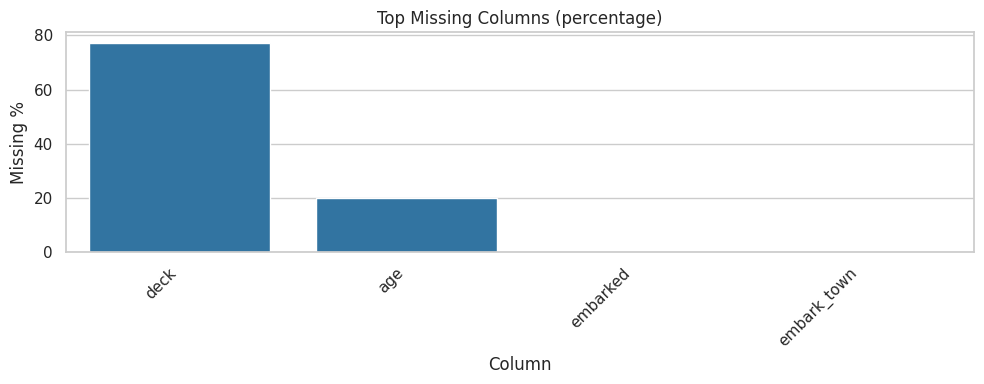


No obvious sentinel values (like -999) were found in numeric columns.


In [13]:
missing_stats = df.isna().sum().to_frame("missing_count")
missing_stats["missing_%"] = (missing_stats["missing_count"] / len(df) * 100).round(2)
missing_stats = missing_stats.sort_values("missing_%", ascending=False)

print("Missingness summary:")
display(missing_stats)

missing_top = missing_stats[missing_stats["missing_count"] > 0].head(10).reset_index()
if not missing_top.empty:
    plt.figure(figsize=(10, 4))
    sns.barplot(data=missing_top, x="index", y="missing_%", color="#1f77b4")
    plt.title("Top Missing Columns (percentage)")
    plt.ylabel("Missing %")
    plt.xlabel("Column")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected - nice but rare!")

# Sentinel value check
sentinel_values = [-999, 9999]
sentinel_hits = {}
for col in numeric_cols:
    hits = df[col].isin(sentinel_values).sum()
    if hits:
        sentinel_hits[col] = int(hits)

if sentinel_hits:
    print("Potential sentinel values found:")
    display(pd.Series(sentinel_hits, name="count"))
else:
    print()
    print("No obvious sentinel values (like -999) were found in numeric columns.")

> **Prompt:** Does missingness appear random or tied to specific passenger classes or embarkation points? What hypotheses would you test next?


In [14]:
# Explore whether missingness is systematic (e.g., tied to passenger class or embarkation)
missing_by_pclass = (
    df.groupby("pclass")[numeric_cols]
    .apply(lambda g: g.isna().sum(), include_groups=False)
    .T
)
print("Missing values by passenger class:")
display(missing_by_pclass)

print()
print("Missing values by embarkation port:")
missing_by_embarked = (
    df.groupby("embarked")[numeric_cols]
    .apply(lambda g: g.isna().sum(), include_groups=False)
    .T
)
display(missing_by_embarked)

Missing values by passenger class:


pclass,1,2,3
pclass,0,0,0
age,30,11,136
sibsp,0,0,0
parch,0,0,0
fare,0,0,0



Missing values by embarkation port:


embarked,C,Q,S
pclass,0,0,0
age,38,49,90
sibsp,0,0,0
parch,0,0,0
fare,0,0,0


> **Prompt:** Is age missingness evenly spread across classes, or concentrated in one? If 3rd class has more missing ages, what imputation strategy might be biased?


## Part 5: Outliers & Heavy Tails

Outliers can be measurement errors, rare-but-real events, or signs of a heavy-tailed distribution. We'll pick a few numeric columns, plot histograms and boxplots, then count outliers using two common rules.

**Two common outlier detection rules:**

| Method           | Formula                                                  | Typical threshold              |
| ---------------- | -------------------------------------------------------- | ------------------------------ |
| **IQR rule**     | Outside $[Q_1 - 1.5 \cdot IQR,\; Q_3 + 1.5 \cdot IQR]$   | 1.5x IQR (default in boxplots) |
| **Z-score rule** | $\lvert z \rvert = \lvert (x - \mu) / \sigma \rvert > k$ | Typically $k = 3$              |


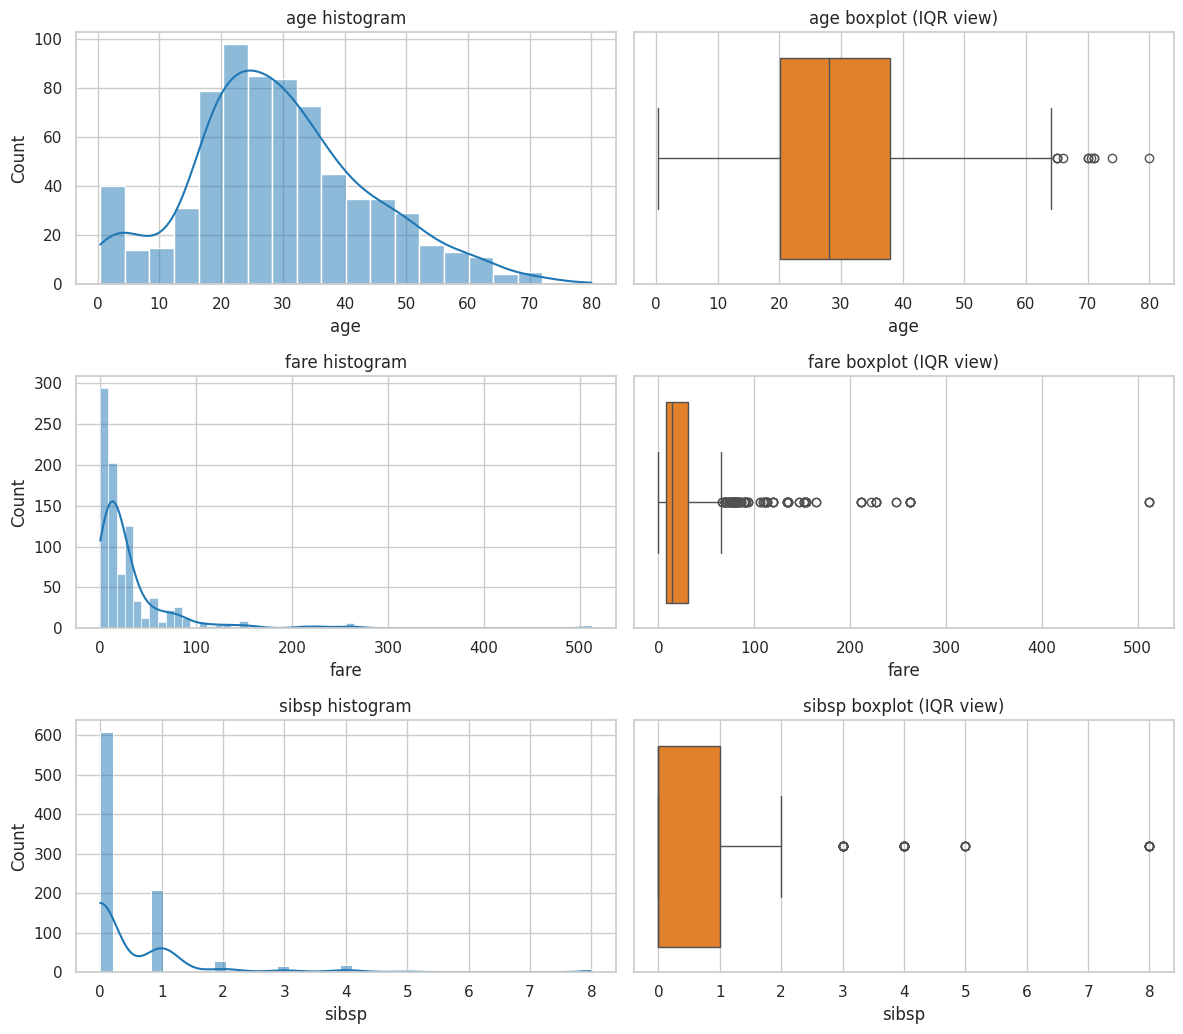

In [15]:
outlier_cols = ["age", "fare", "sibsp"]
fig, axes = plt.subplots(len(outlier_cols), 2, figsize=(12, len(outlier_cols) * 3.5))
axes = np.array(axes).reshape(len(outlier_cols), 2)
for idx, col in enumerate(outlier_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx, 0], color="#1f77b4")
    axes[idx, 0].set_title(f"{col} histogram")
    sns.boxplot(x=df[col], ax=axes[idx, 1], color="#ff7f0e")
    axes[idx, 1].set_title(f"{col} boxplot (IQR view)")
plt.tight_layout()
plt.show()

In [16]:
def iqr_outlier_mask(series: pd.Series, multiplier: float = 1.5):
    """Return boolean mask where True = outlier by IQR rule."""
    clean = series.dropna()
    if clean.empty:
        return pd.Series(False, index=series.index)
    q1, q3 = clean.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - multiplier * iqr
    upper = q3 + multiplier * iqr
    mask = (series < lower) | (series > upper)
    return mask.fillna(False)


def zscore_outlier_mask(series: pd.Series, threshold: float = 3.0):
    """Return boolean mask where True = outlier by z-score rule."""
    clean = series.dropna()
    if clean.std(ddof=0) == 0 or clean.empty:
        return pd.Series(False, index=series.index)
    z = (series - clean.mean()) / clean.std(ddof=0)
    mask = z.abs() > threshold
    return mask.fillna(False)


outlier_summary = []
for col in outlier_cols:
    iqr_mask = iqr_outlier_mask(df[col])
    z_mask = zscore_outlier_mask(df[col])
    outlier_summary.append(
        {
            "column": col,
            "iqr_outliers": int(iqr_mask.sum()),
            "z>3_outliers": int(z_mask.sum()),
        }
    )

print("Outlier counts by method:")
display(pd.DataFrame(outlier_summary))

Outlier counts by method:


,column,iqr_outliers,z>3_outliers
0,age,11,2
1,fare,116,20
2,sibsp,46,30


> **Prompt:** For each flagged outlier, would you treat it as an error, a rare-but-real event, or something to model explicitly?


## Part 6: Relationships (Scatter + Correlation)

Visualizing relationships helps you understand which features might predict the target and which features are redundant with each other.

**Understanding the family size features:**

- `sibsp` = number of siblings/spouses aboard
- `parch` = number of parents/children aboard

We'll show a **survival rate heatmap** for family size — each cell shows what fraction of passengers with that (sibsp, parch) combination survived. This reveals patterns like "medium-sized families survived better than solo travelers or very large families."

A **correlation heatmap** summarizes all pairwise numeric relationships, and we'll also compute **feature-target correlations** to see which numeric features are most associated with survival. Watch for:

- **Predictive features** — features that correlate with the target (positive or negative).
- **Redundant features** — highly correlated pairs that carry the same information.
- **Leakage risks** — features that correlate suspiciously well with the target (they might encode the answer).


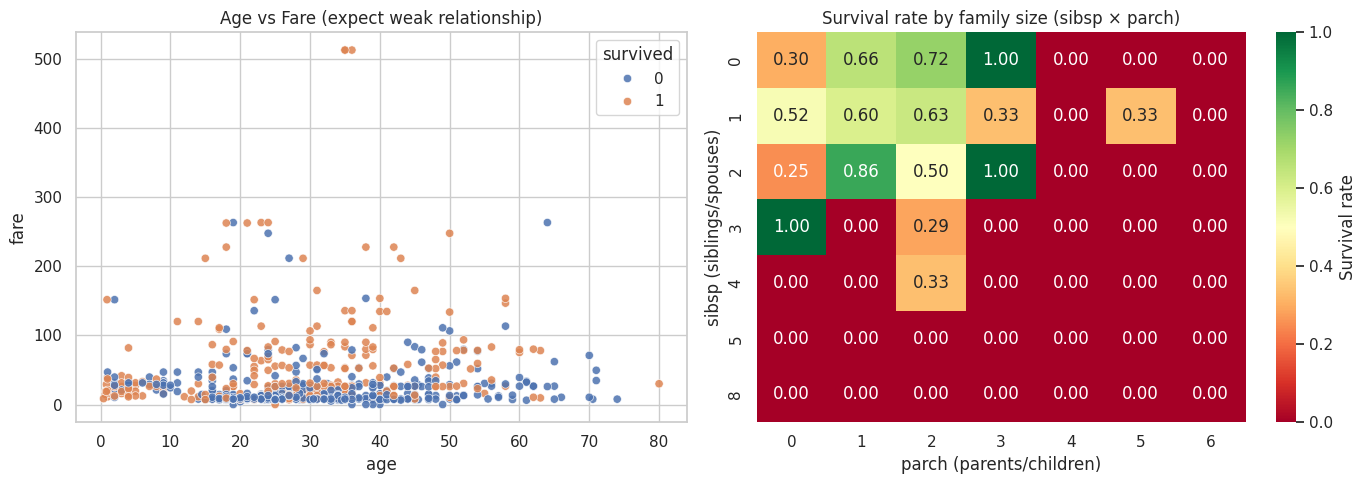

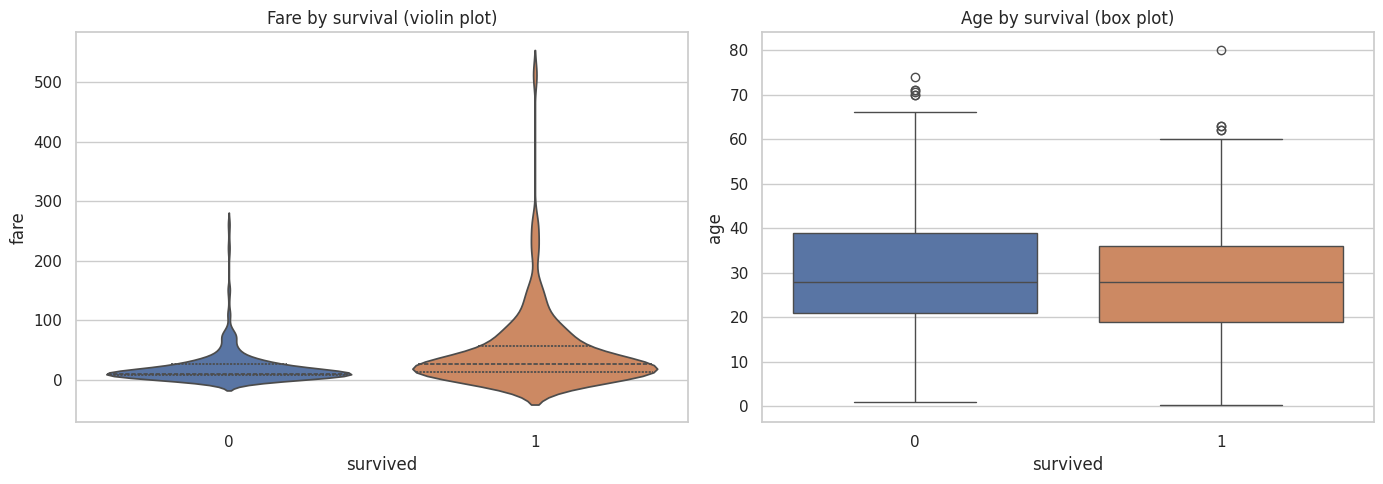

In [17]:
# Feature-feature scatter: Age vs Fare
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

subset = df[["age", "fare", target_col]].dropna()
sns.scatterplot(data=subset, x="age", y="fare", hue=target_col, ax=axes[0], alpha=0.85)
axes[0].set_title("Age vs Fare (expect weak relationship)")

# Family size survival heatmap: shows survival RATE by sibsp/parch combination
survival_by_family = (
    df.groupby(["sibsp", "parch"])[target_col].mean().unstack(fill_value=0)
)
sns.heatmap(
    survival_by_family,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    ax=axes[1],
    cbar_kws={"label": "Survival rate"},
)
axes[1].set_title("Survival rate by family size (sibsp × parch)")
axes[1].set_xlabel("parch (parents/children)")
axes[1].set_ylabel("sibsp (siblings/spouses)")

plt.tight_layout()
plt.show()

# Feature vs. target: use violin/box plots for binary targets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin plot shows distribution shape (better than strip plot for overlapping data)
sns.violinplot(
    data=df,
    x=target_col,
    y="fare",
    hue=target_col,
    split=False,
    inner="quartile",
    ax=axes[0],
    legend=False,
)
axes[0].set_title("Fare by survival (violin plot)")

# Box plot shows distribution summary
sns.boxplot(data=df, x=target_col, y="age", hue=target_col, ax=axes[1], legend=False)
axes[1].set_title("Age by survival (box plot)")

plt.tight_layout()
plt.show()

> **Prompt:** In the scatter plots, do survivors (orange) cluster in different regions than non-survivors (blue)? Which feature looks more predictive of survival — `fare` or `age`?


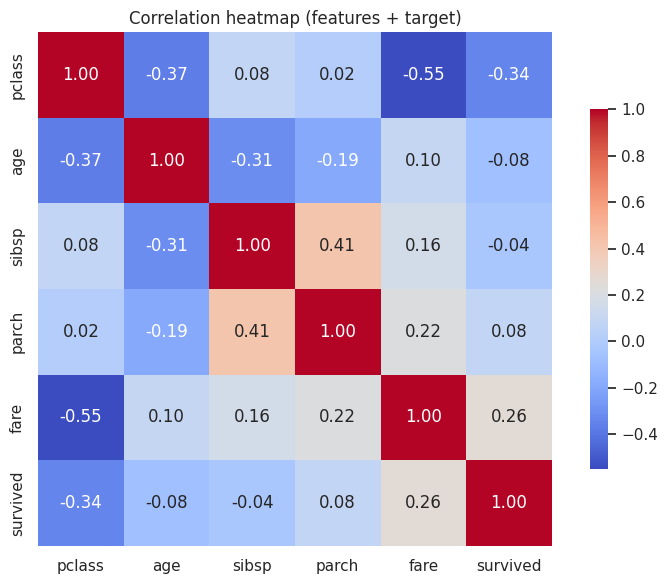

Top correlated pairs (including target):


,feature_a,feature_b,abs_correlation
0,pclass,fare,0.549
1,sibsp,parch,0.415
2,pclass,age,0.369
3,pclass,survived,0.338
4,age,sibsp,0.308
5,fare,survived,0.257
6,parch,fare,0.216
7,age,parch,0.189
8,sibsp,fare,0.160
9,age,fare,0.096


In [18]:
corr_matrix = df[numeric_cols + [target_col]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.7},
)
plt.title("Correlation heatmap (features + target)")
plt.tight_layout()
plt.show()

# List top correlated pairs (excluding self-correlation)
abs_corr = (
    corr_matrix.abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
top_pairs = abs_corr.head(10).rename("abs_correlation").reset_index()
top_pairs.columns = ["feature_a", "feature_b", "abs_correlation"]
print("Top correlated pairs (including target):")
display(top_pairs)

> **Prompt:** Which feature pairs have |correlation| > 0.4? Would dropping one of a highly correlated pair simplify your model without losing predictive power?


## Part 7: Feature Scaling with scikit-learn

Many algorithms (PCA, logistic regression, k-NN, neural networks) are sensitive to feature scales. **Feature scaling** is the umbrella term for transforming features to comparable ranges.

> **Terminology note:** Strictly speaking, _normalization_ means scaling to a bounded range like [0, 1] (what `MinMaxScaler` does), while _standardization_ means centering to mean=0 and scaling to std=1 (what `StandardScaler` does). However, you'll often hear people use "normalization" loosely to mean any scaling — don't let the sloppy terminology confuse you.

We'll compare two common approaches:

- **StandardScaler** (standardization) — centers to mean=0 and scales to std=1. Preferred for PCA and gradient-based methods.
- **MinMaxScaler** (normalization) — rescales to [0, 1]. Useful when you need bounded ranges or for k-NN with features on very different scales.

| Scaler           | Transform                                  | When to use                                    |
| ---------------- | ------------------------------------------ | ---------------------------------------------- |
| `StandardScaler` | $z = (x - \mu) / \sigma$                   | PCA, logistic regression, SVM, neural networks |
| `MinMaxScaler`   | $x' = (x - x_{min}) / (x_{max} - x_{min})$ | k-NN, when bounded [0,1] range is needed       |

### Reversing the Transformation

After training, you often need to convert predictions or coefficients back to the **original scale** for interpretation. Scikit-learn scalers provide `inverse_transform()` for exactly this purpose — essential when you need to report results in human-readable units (e.g., "predicted fare: $32.50" instead of "predicted fare: -0.31").


### StandardScaler (Standardization)

StandardScaler transforms each feature to have mean=0 and standard deviation=1. This is the most common choice for algorithms that assume normally distributed inputs or use gradient-based optimization.


fare before/after standardization:


,metric,value
0,mean_before,3.220e+01
1,std_before,4.967e+01
2,mean_after,3.987e-18
3,std_after,1.000e+00


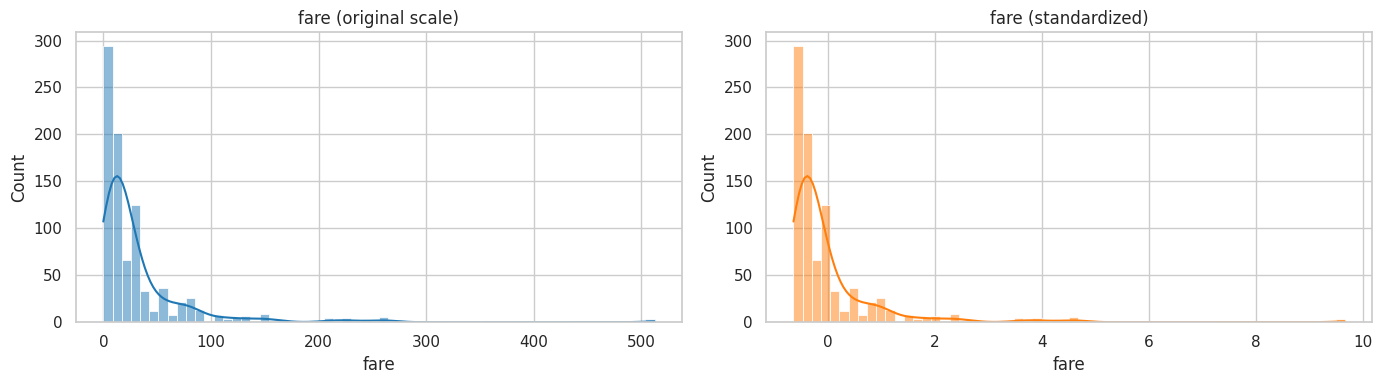

In [19]:
numeric_imputed = df[numeric_cols].copy()
numeric_imputed = numeric_imputed.fillna(numeric_imputed.median())

standard_scaler = StandardScaler()
standard_scaled = pd.DataFrame(
    standard_scaler.fit_transform(numeric_imputed),
    columns=numeric_cols,
)

focus_col = "fare"
comparison = pd.DataFrame(
    {
        "metric": ["mean_before", "std_before", "mean_after", "std_after"],
        "value": [
            numeric_imputed[focus_col].mean(),
            numeric_imputed[focus_col].std(ddof=0),
            standard_scaled[focus_col].mean(),
            standard_scaled[focus_col].std(ddof=0),
        ],
    }
)
print(f"{focus_col} before/after standardization:")
display(comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(numeric_imputed[focus_col], kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title(f"{focus_col} (original scale)")
sns.histplot(standard_scaled[focus_col], kde=True, ax=axes[1], color="#ff7f0e")
axes[1].set_title(f"{focus_col} (standardized)")
plt.tight_layout()
plt.show()

### MinMaxScaler (Normalization)

MinMaxScaler rescales features to a fixed range, typically [0, 1]. Unlike StandardScaler, it preserves zero entries in sparse data and guarantees bounded outputs — useful for algorithms sensitive to feature magnitudes.


age before/after MinMax scaling:


,metric,value
0,min_before,0.42
1,max_before,80.00
2,min_after,0.00
3,max_after,1.00


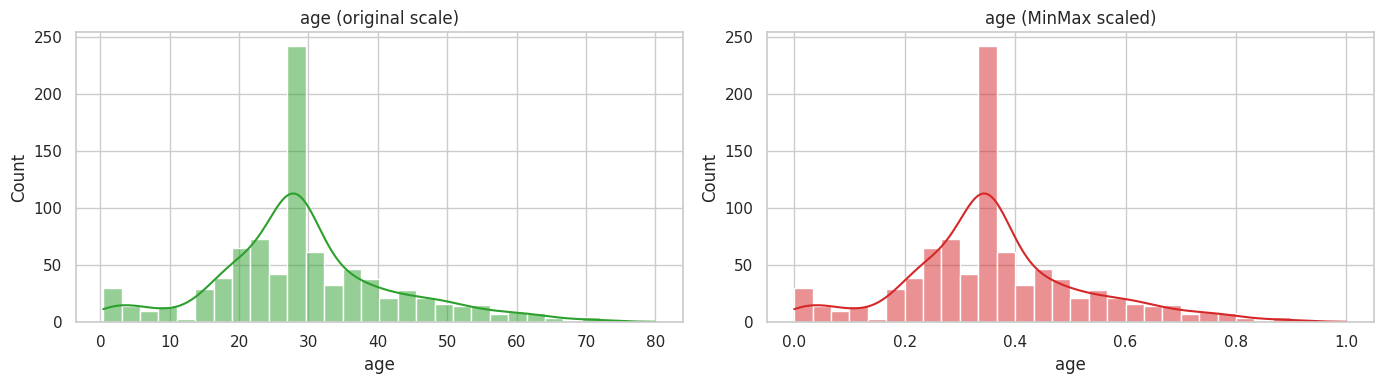

In [20]:
minmax_scaler = MinMaxScaler()
minmax_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(numeric_imputed),
    columns=numeric_cols,
)

focus_col_minmax = "age"
minmax_comparison = pd.DataFrame(
    {
        "metric": ["min_before", "max_before", "min_after", "max_after"],
        "value": [
            numeric_imputed[focus_col_minmax].min(),
            numeric_imputed[focus_col_minmax].max(),
            minmax_scaled[focus_col_minmax].min(),
            minmax_scaled[focus_col_minmax].max(),
        ],
    }
)
print(f"{focus_col_minmax} before/after MinMax scaling:")
display(minmax_comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(numeric_imputed[focus_col_minmax], kde=True, ax=axes[0], color="#2ca02c")
axes[0].set_title(f"{focus_col_minmax} (original scale)")
sns.histplot(minmax_scaled[focus_col_minmax], kde=True, ax=axes[1], color="#d62728")
axes[1].set_title(f"{focus_col_minmax} (MinMax scaled)")
plt.tight_layout()
plt.show()

### Inverse Transform: Converting Back to Original Scale

After modeling, you'll often need to **inverse transform** values back to interpretable units. Scikit-learn scalers store the parameters learned during `fit()` and expose `inverse_transform()` to reverse the scaling.


In [21]:
# Demonstrate denormalization (inverse_transform)
# Suppose we have a normalized prediction and need to report it in original units

# Pick a sample of normalized fare values
sample_normalized = standard_scaled[["fare"]].head(5)

# Denormalize back to original scale
# Note: inverse_transform expects all columns that were fit, so we use the full array
sample_denormalized = standard_scaler.inverse_transform(standard_scaled.head(5))
sample_denormalized_df = pd.DataFrame(sample_denormalized, columns=numeric_cols)

# Compare: normalized vs denormalized vs actual original
comparison_df = pd.DataFrame(
    {
        "original": numeric_imputed["fare"].head(5).values,
        "normalized": standard_scaled["fare"].head(5).values,
        "denormalized": sample_denormalized_df["fare"].values,
    }
)

print("Round-trip demonstration: original → normalized → denormalized")
display(comparison_df)

print()
print("✓ Denormalized values match the original (within floating-point precision)")
print("  This is essential for interpreting model outputs in real-world units.")

Round-trip demonstration: original → normalized → denormalized


,original,normalized,denormalized
0,7.250,-0.502,7.250
1,71.283,0.787,71.283
2,7.925,-0.489,7.925
3,53.100,0.421,53.100
4,8.050,-0.486,8.050



✓ Denormalized values match the original (within floating-point precision)
  This is essential for interpreting model outputs in real-world units.


> **Prompt:** Which scaler is more appropriate for PCA or k-NN on this dataset, and why? When might you deliberately keep features on their original scale? In what scenarios would you need to denormalize your model's predictions?


## Part 8: Split Strategies & Leakage Safety

We'll use a lightweight baseline model (logistic regression) purely to demonstrate how evaluation protocols change the story. Every pipeline below keeps preprocessing inside `Pipeline`/`ColumnTransformer` so scalers learn from training folds only - **this prevents data leakage automatically**.

### A Quick Word on Logistic Regression

**Logistic regression** is a classification algorithm that predicts the probability of a binary outcome (here: survived vs. died). Despite the name, it's used for _classification_, not regression.

- **How it works:** Computes a weighted sum of features, then squashes the result through a sigmoid function to get a probability between 0 and 1.
- **Decision rule:** If probability > 0.5, predict class 1 (survived); otherwise predict class 0 (died).
- **Why we use it here:** It's simple, fast, and interpretable — perfect for demonstrating evaluation strategies without getting distracted by model complexity.

You'll explore logistic regression in more depth in later labs. For now, just think of it as a "good enough" classifier that lets us focus on _how we evaluate_, not _what we evaluate_.


In [22]:
model_df = df.dropna(subset=[target_col]).copy()
X_all = model_df[feature_cols]
y_all = model_df[target_col]

numeric_features = [col for col in numeric_cols if col in feature_cols]
categorical_features = [col for col in categorical_cols if col in feature_cols]

print(f"Modeling rows: {X_all.shape[0]} (dropped rows missing target)")
print(f"Numeric features used: {numeric_features}")
print(f"Categorical features used: {categorical_features}")


def make_preprocessor():
    """Build a ColumnTransformer for numeric + categorical features."""
    # Numeric pipeline: fill missing values with median, then standardize to mean=0, std=1
    numeric_transformer = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(strategy="median"),
            ),  # Replace NaN with column median
            ("scaler", StandardScaler()),  # Center and scale: z = (x - mean) / std
        ]
    )
    # Categorical pipeline: fill missing with most common value, then one-hot encode
    categorical_transformer = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(strategy="most_frequent"),
            ),  # Replace NaN with mode
            (
                "encoder",
                OneHotEncoder(handle_unknown="ignore"),
            ),  # Create binary columns per category
        ]
    )
    # ColumnTransformer applies different pipelines to different column subsets
    # This keeps numeric and categorical preprocessing separate and explicit
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )


def build_baseline_pipeline(C: float = 1.0):
    """Return a full pipeline: preprocessing -> logistic regression.

    C controls regularization strength (smaller C = stronger regularization).
    """
    return Pipeline(
        steps=[
            ("preprocess", make_preprocessor()),  # All preprocessing in one step
            ("model", LogisticRegression(max_iter=500, C=C)),  # Classification model
        ]
    )

Modeling rows: 891 (dropped rows missing target)
Numeric features used: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical features used: ['embarked', 'sex']


### 8.0 Baseline Model (model_0)

Before building real models, we establish a **baseline** — the minimum accuracy we should beat. A `DummyClassifier` with `strategy="most_frequent"` always predicts the majority class. If our logistic regression can't beat this, we have no real signal.

**Important:** We split off a single test set here that will be reused in sections 8.1–8.3. This lets us directly compare results across different training strategies on the exact same held-out data.


In [23]:
# Split off test set ONCE — this same test set is reused in 8.1, 8.2, and 8.3
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=SEED
)

print(f"Full dataset: {len(X_all)} rows")
print(f"Train+Val pool: {len(X_trainval)} | Test (held out): {len(X_test)}")
print()

# model_0: always predict the majority class
model_0 = DummyClassifier(strategy="most_frequent")
model_0.fit(X_trainval, y_trainval)
baseline_acc = model_0.score(X_test, y_test)

print("\n→ Any useful model must beat this floor!")

print(f"Target distribution: {y_all.value_counts(normalize=True).to_dict()}")
print(f"\nmodel_0 (majority class): test accuracy = {baseline_acc:.3f}")

Full dataset: 891 rows
Train+Val pool: 712 | Test (held out): 179


→ Any useful model must beat this floor!
Target distribution: {0: 0.6161616161616161, 1: 0.3838383838383838}

model_0 (majority class): test accuracy = 0.615


### 8.1 Train/Test Split (baseline sanity check)

Use when you need a quick read on signal and are not tuning hyperparameters. The pipeline automatically fits the scaler on train data only.


In [24]:
# Use the full train+val pool as training data (no validation split)
print(f"Train size: {len(X_trainval)} | Test size: {len(X_test)}")
print()

tt_pipeline = build_baseline_pipeline(C=1.0)
tt_pipeline.fit(X_trainval, y_trainval)
train_acc = tt_pipeline.score(X_trainval, y_trainval)
test_acc = tt_pipeline.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy : {test_acc:.3f}")

print()

tt_preds = tt_pipeline.predict(X_test)
print("Classification report (test set):")
print(classification_report(y_test, tt_preds, digits=3))

Train size: 712 | Test size: 179

Train accuracy: 0.808
Test accuracy : 0.804

Classification report (test set):
              precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179



> **Prompt:** Is the gap between train and test accuracy large? What would a big gap suggest about overfitting?


### 8.2 Train/Val/Test Split (model selection without CV)

Use when you expect to iterate on preprocessing choices or **hyperparameters**, and you want a final untouched test set for the report.

**What are hyperparameters?** Unlike model _parameters_ (e.g., regression coefficients) that are learned from data, **hyperparameters** are settings you choose _before_ training — they control how the learning algorithm behaves. Examples include:

- Regularization strength (`C` in logistic regression)
- Learning rate (in gradient descent)
- Number of trees (in random forests)

You can't learn hyperparameters from training data without risking overfitting — that's why you need a separate **validation set** to compare different choices.


In [25]:
# Split the train+val pool into train and validation (test set unchanged from 8.0)
X_train_tv, X_val, y_train_tv, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=SEED
)

print(
    f"Train: {len(X_train_tv)} | Val: {len(X_val)} | Test: {len(X_test)} (same as 8.0)"
)
print()

# Try different regularization strengths (log scale is typical for C)
Cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
val_results = []
for C in Cs:
    candidate = build_baseline_pipeline(C=C)
    candidate.fit(X_train_tv, y_train_tv)
    val_acc = candidate.score(X_val, y_val)
    val_results.append({"C": C, "val_accuracy": val_acc})

val_df = pd.DataFrame(val_results).sort_values("val_accuracy", ascending=False)
print("Validation results (different regularization strengths):")
display(val_df)

best_C = val_df.iloc[0]["C"]
print()
print(f"Best C based on validation: {best_C}")

# Retrain on full train+val pool with best hyperparameter, then evaluate on test
final_pipeline = build_baseline_pipeline(C=best_C)
final_pipeline.fit(X_trainval, y_trainval)
final_test_acc = final_pipeline.score(X_test, y_test)

print()
print(
    f"Final test accuracy (after selecting hyperparams on val set): {final_test_acc:.3f}"
)

Train: 569 | Val: 143 | Test: 179 (same as 8.0)

Validation results (different regularization strengths):


,C,val_accuracy
4,10.000,0.769
2,0.100,0.769
5,100.000,0.769
3,1.000,0.762
1,0.010,0.755
0,0.001,0.629



Best C based on validation: 10.0

Final test accuracy (after selecting hyperparams on val set): 0.810


> **Prompt:** Did the best C from validation also perform well on test? If validation and test accuracy differ substantially, what might explain it?


### 8.3 Cross-Validation (reducing variance)

Use when data is small/medium and a single split is too noisy. Pipelines ensure every fold fits preprocessing on its training fold only.


In [26]:
# Do 5-fold CV on the train+val pool (test set unchanged from 8.0)
cv_pipeline = build_baseline_pipeline(C=10.0)
cv_scores = cross_val_score(
    cv_pipeline, X_trainval, y_trainval, cv=5, scoring="accuracy"
)

print(f"Train+Val pool: {len(X_trainval)} | Test: {len(X_test)} (same as 8.0)")
print()
print("Cross-validation accuracy (5-fold on train+val pool):")
print(cv_scores)
print(f"Mean ± std: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Final evaluation on the same held-out test set
cv_pipeline.fit(X_trainval, y_trainval)
test_acc_cv = cv_pipeline.score(X_test, y_test)
print()
print(f"Final test accuracy (same test set as 8.0–8.2): {test_acc_cv:.3f}")

Train+Val pool: 712 | Test: 179 (same as 8.0)

Cross-validation accuracy (5-fold on train+val pool):
[0.79020979 0.75524476 0.78873239 0.81690141 0.80985915]
Mean ± std: 0.792 ± 0.021

Final test accuracy (same test set as 8.0–8.2): 0.810


### 8.4 When to Use What

| Strategy             | When to use                                                                                                        |
| -------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **Train/Test only**  | Quick sanity checks, no tuning, plenty of data, low stakes                                                         |
| **Train/Val/Test**   | You will iterate on preprocessing/features/hyperparameters and need a final untouched exam set                     |
| **Cross-Validation** | Data is limited or noisy, you want a robust estimate; often paired with a final hold-out test for the final report |


## Key Takeaways

1. **Explore before you model.** Summary statistics, histograms, and scatter plots reveal data quality issues that break models.

2. **Missing values and outliers require judgment.** Detection is mechanical; deciding what to do about them is domain knowledge.

3. **Normalization matters for distance-based methods.** Use `StandardScaler` for PCA/logistic regression; `MinMaxScaler` when you need bounded ranges. Remember to denormalize predictions when reporting results in real-world units.

4. **Pipelines prevent leakage.** Fit preprocessing on train data only - scikit-learn pipelines handle this automatically inside CV.

5. **Choose your split strategy deliberately.** Train/test for quick checks; train/val/test for iterative tuning; CV for robust estimates on small data.

### The Red Thread from Lab 06

In Lab 06, you saw gradient descent crawling along an error surface to find optimal weights. That algorithm _assumes_ your features are:

- **Clean** — no missing values crashing the computation
- **Normalized** — otherwise the error surface is elongated and descent zigzags
- **Properly split** — so the test score reflects real performance, not overfitting

Today you learned the preprocessing skills that make gradient descent work in practice. **Bad data beats good algorithms every time - now you know how to avoid that trap.**
